# Introduction
Bonklenet is CNN learning project intended to identify Kanohi masks from the LEGO Bionicle toyline.

The model will be trained off of the Nui Rama Image Dataset, the initial version of which will only include the masks from the 2001 series of Bionicle figures with images of the masks grabbed from Bricklink and personal collections. This dataset covers a total of 12 masks. The plan is to expand the dataset over time and update the model accordingly.

Special thanks to the Tensorflow team and Nicholas Renotte for creating easy to follow tutorials.

In [1]:
#importing the libraries
import os
import cv2
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
import imghdr

In [2]:
data_dir = '/content/nui_rama'

# Data Preperation
The dataset is prepared for using the built in Tensorflow generation function.

There are currently 12 classes in the data set, each one corresponding to a particular mask from the grouping of: Miru, Kaukau, Huna, Pakari, Mahiki, Rau, Hau, Ruru, Komau, Matatu, Akaku, and Kakama.

Found 88 files belonging to 12 classes.


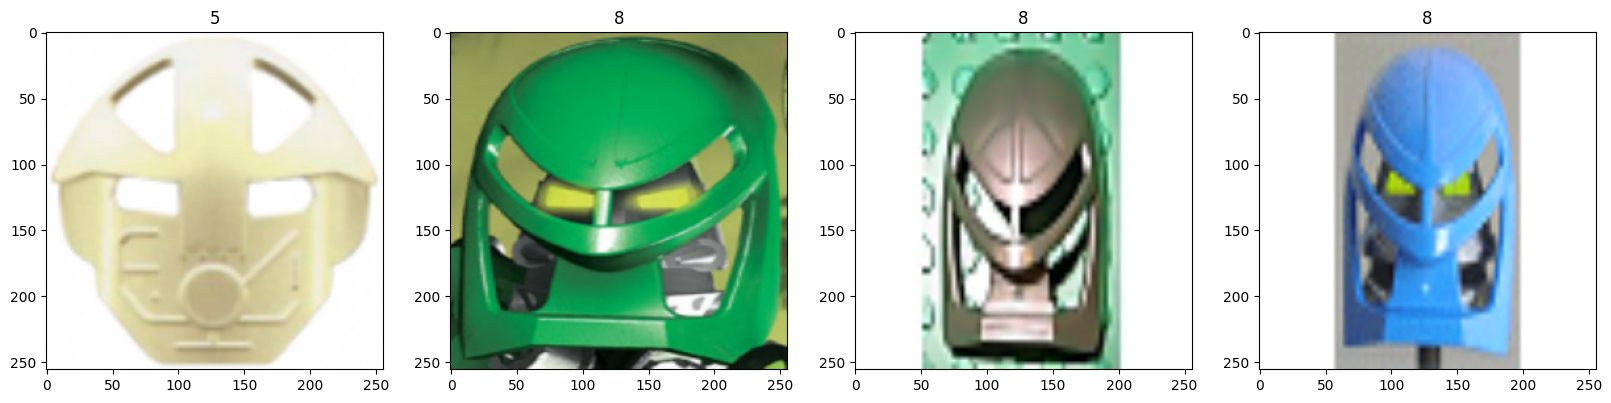

In [3]:
data = tf.keras.utils.image_dataset_from_directory('/content/nui_rama', batch_size=11)
data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [4]:
data = data.map(lambda x,y: (x/255,y))
data.as_numpy_iterator().next()

train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

train_size

train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

train_size
train

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [6]:
model = Sequential()

# Model
The Bonklenet model consists of 9 layers, including a dropout layer in order to reduce overfitting.
It will be trained over 30 epochs using the previously prepared Nui Rama Dataset.

In [7]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(12, activation='softmax'))

In [8]:
model.compile(loss=tf.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'], optimizer='adam')

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 16)      0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 127, 127, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      9280      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 64)        3

In [10]:
logdir='logs'

In [11]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)


In [12]:
hist = model.fit(train, epochs=30, validation_data=val, callbacks=[tensorboard_callback])


Epoch 1/30
5/5 [==============================] - 9s 1s/step - loss: 5.7260 - accuracy: 0.0364 - val_loss: 2.4678 - val_accuracy: 0.0000e+00
Epoch 2/30
5/5 [==============================] - 7s 1s/step - loss: 2.4924 - accuracy: 0.0909 - val_loss: 2.4652 - val_accuracy: 0.0909
Epoch 3/30
5/5 [==============================] - 6s 1s/step - loss: 2.4663 - accuracy: 0.2182 - val_loss: 2.3382 - val_accuracy: 0.3636
Epoch 4/30
5/5 [==============================] - 7s 1s/step - loss: 2.4976 - accuracy: 0.1818 - val_loss: 2.3541 - val_accuracy: 0.2727
Epoch 5/30
5/5 [==============================] - 7s 1s/step - loss: 2.3836 - accuracy: 0.2727 - val_loss: 2.5538 - val_accuracy: 0.0000e+00
Epoch 6/30
5/5 [==============================] - 6s 1s/step - loss: 2.3270 - accuracy: 0.2909 - val_loss: 1.8475 - val_accuracy: 0.4545
Epoch 7/30
5/5 [==============================] - 7s 1s/step - loss: 2.1496 - accuracy: 0.3818 - val_loss: 1.8322 - val_accuracy: 0.5455
Epoch 8/30
5/5 [=================

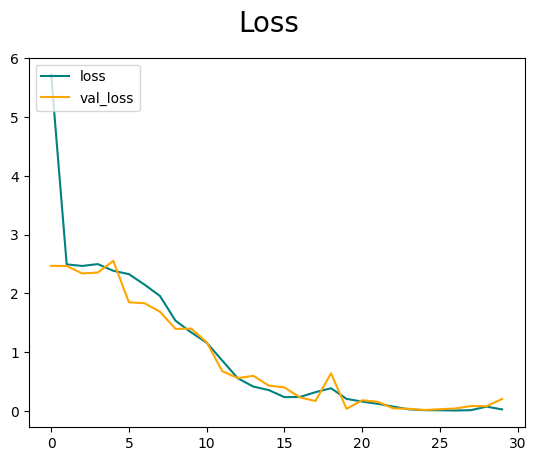

In [13]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

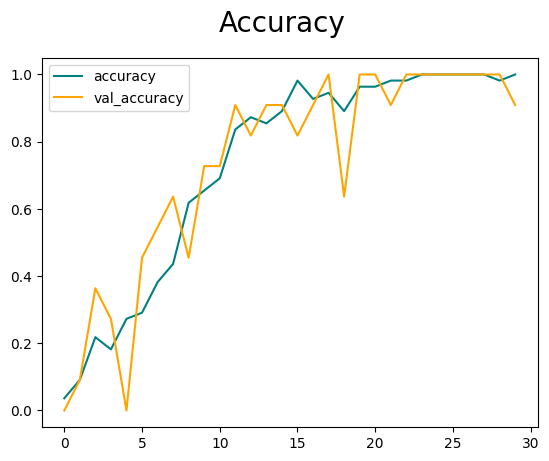

In [14]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [15]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy


In [16]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [17]:
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

In [18]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(0.0, shape=(), dtype=float32) tf.Tensor(0.0, shape=(), dtype=float32) tf.Tensor(0.0, shape=(), dtype=float32)


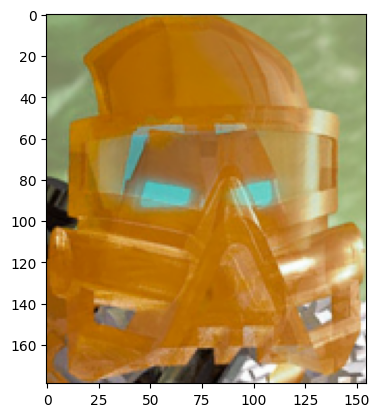

In [19]:
img = cv2.imread('/content/nui_rama/Kaukau/155px-Kaukau.png')
img2 = cv2.imread('/content/nui_rama/Kaukau/kaukau34.png')
plt.imshow(img)
plt.show()

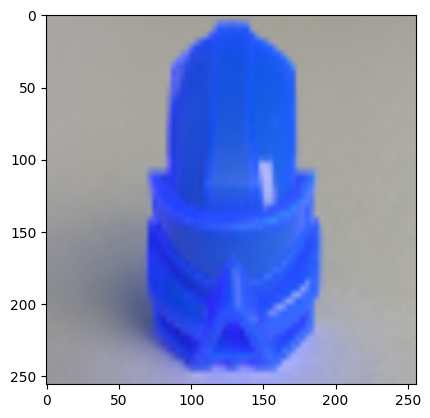

In [20]:
resize = tf.image.resize(img, (256,256))
resize2 = tf.image.resize(img2, (256,256))
plt.imshow(resize2.numpy().astype(int))
plt.show()

In [21]:
predict_x=model.predict(np.expand_dims(resize/255, 0))
classes_x=np.argmax(predict_x,axis=1)
print(classes_x)

1/1 [==============================] - 0s 209ms/step
[1]


In [22]:
predict_x2=model.predict(np.expand_dims(resize2/255, 0))
classes_x2=np.argmax(predict_x2,axis=1)
print(classes_x2)

1/1 [==============================] - 0s 71ms/step
[1]
